# Модель для оператора мобильной связи "Мегалайн"

***
### Задача:

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».
В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель, которая порекомендует подходящий тариф для клиента. 


### Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
    
* сalls — количество звонков,
* minutes — суммарная длительность звонков в минутах,
* messages — количество sms-сообщений,
* mb_used — израсходованный интернет-трафик в Мб,
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).


***

### План работ:

**[Шаг 1.](#section_1)** Загрузка данных, изучение общей информации.

**[Шаг 2.](#section_2)** Раздение исходных данных на обучающую, валидационную и тестовую выборки.

**[Шаг 3.](#section_3)** Исследование различных моделей.

**[Шаг 4.](#section_4)** Проверка выбранной модели на тестовой выборке.

**[Шаг 5.](#section_5)** Проверка выбранной модели на адекватность.

**[Шаг 6.](#section_6)** Общий вывод.



<a id='section_1'></a>
### Шаг 1. Загрузка данных, изучение общей информации:

In [1]:
#Загрузка нужных библиотек:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier


In [2]:
#Сохраняем данные в датафрейм
users = pd.read_csv('C:/Users/ratus/DATA_SCIENCE/итоговые проекты/4/users_behavior.csv')

In [3]:
#Общая информация по датафрейму
users.info()

#Несколько строк датафрейма
users.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [4]:
#Процент пропущ. значений для каждого столбца датафрейма
(users.isna().mean() * 100).sort_values(ascending=False).to_frame()

,0
calls,0.0
minutes,0.0
messages,0.0
mb_used,0.0
is_ultra,0.0


В полученных данных содержится информация о 3214 пользователях.

С типами столбцов и названиями все ок, пропусков нет.

In [5]:
#Поиск дубликаты по всему датафрейму
users.duplicated().sum()

0

Дубликатов тоже нет.

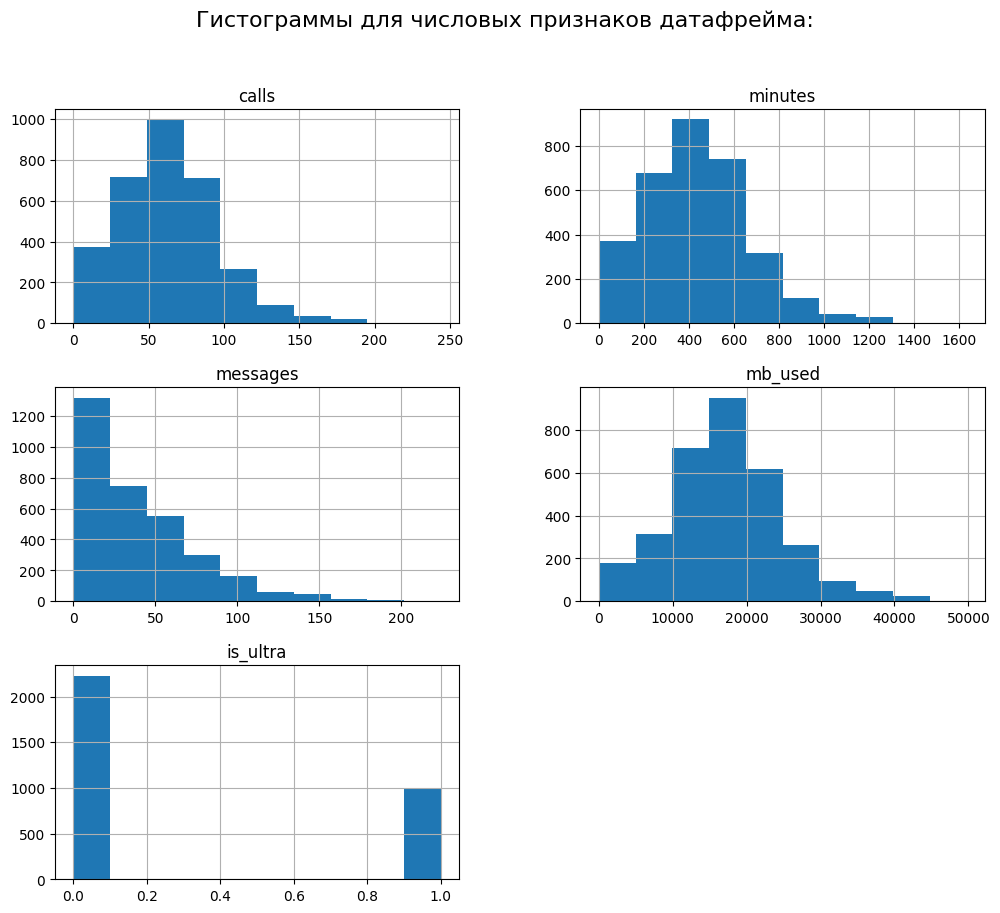

In [6]:
# Общая гистограмма для всех числовых столбцов
users.hist(figsize=(12, 10));
plt.suptitle('Гистограммы для числовых признаков датафрейма:', fontsize=16);

Аномальных данных и выбросов тоже нет.

Посмотрим на частоту значений целевого признака:

In [7]:
users['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

Видно что клиентов с тарифом Smart существенно больше чем с тарифом Ultra.

Посмотрим влияние различных признаков на целевой:

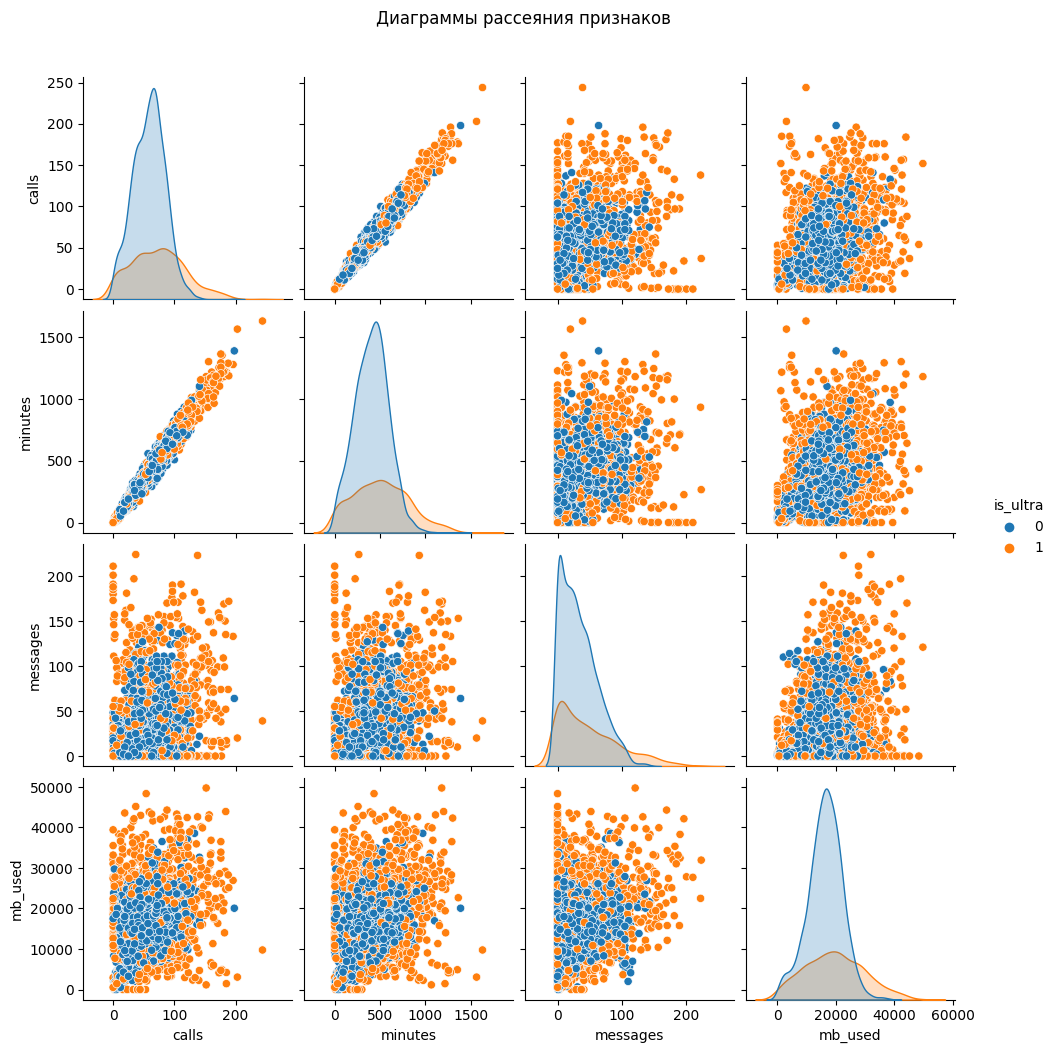

In [8]:
sns.pairplot(users, hue = 'is_ultra')
plt.suptitle('Диаграммы рассеяния признаков', y=1.05);

На графике можно заметить четкую прямую связь между минутами и звонками, что логично, и видно что клиенты с тарифом Ultra разговаривают дольше чем с тарифом Smart. Пользователи тарифа Ultra также совершают больше звонков и отправляют сообщений.

На гистограме также заметен тот факт что пользователей тарифа Smart больше. 


<a id='section_2'></a>
### Шаг 2. Разделим исходные данные на обучающую, валидационную и тестовую выборки:

В обучающую выборку поместим 60%, в валидационную и тестовую по 20%.

In [9]:
#Выделим из датафрейма общий набор признаков и целевой признак
features = users.drop(['is_ultra'], axis=1)
target = users['is_ultra']

#Отделим 20% в тестовую выборку features_test, target_test
features_part, features_test, target_part, target_test = train_test_split(
   features, target, test_size = 0.20, random_state=123) 

#Отделим еще 20% в валидационную выборку features_valid, target_valid
#оставшиеся 60% будут в обучающей features_train,target_train
features_train, features_valid, target_train, target_valid = train_test_split(
   features_part, target_part, test_size = 0.25, random_state=123) 

#Проверим размер выборок
print (len(features_train), len(features_valid), len(features_test))

1928 643 643


<a id='section_3'></a>
### Шаг 3. Исследуем разные модели:

В целевом признаке 2 тарифа, следовательно перед нами задача классификации. 

Переберем разные модели для классификации: решающее дерево, случайный лес и логистическая регрессия.

И в нашем случае каждое неправильное предсказание — это неверная подсказка и потенциальная упущенная выгода для компании. И наоборот: чем выше точность классификации, тем больше прибыли принесёт продукт. Поэтому для оценки качества моделей будем использовать метрику `accuracy`.

Начнем с построения модели решающего дерева. Подберем гиперпараметры (например глубину дерева, мин. кол-во примеров для разделения и мин. кол-во объектов в листе), чтобы найти оптимальное решающее дерево:

In [10]:
#Cоздаем словарик, содержащий параметры, которые будем подбирать GridSearch’ем
parametrs = { 'max_depth': range (1,15,1),
            'min_samples_leaf': range (1,20,2),
            'min_samples_split': range (2,20,1)}

#Запускаем обучение
grid = GridSearchCV(DecisionTreeClassifier(random_state=123), parametrs);
grid.fit(features_train, target_train);

#Смотрим лучший результат:
grid.best_params_

{'max_depth': 6, 'min_samples_leaf': 15, 'min_samples_split': 2}

Наилучшими гиперпараметрами модели решающего дерева являются:
* глубину дерева = 6, 
* мин. кол-во примеров для разделения = 15,
* мин. кол-во объектов в листе = 2.

Посмотрим качество модели с такими параметрами на валидационной выборке:

In [11]:
#Создаем модель с указанными параметрами
best_model_tree = DecisionTreeClassifier(
    random_state=123, 
    max_depth= 6,
    min_samples_leaf= 15, 
    min_samples_split= 2)
#Обучаем
best_model_tree.fit(features_train, target_train) 

#Смотрим качество модели на валидационной выборке
best_result_tree = best_model_tree.score(features_valid, target_valid) 

print('Accuracy на валидационной выборке {:.2f}'.format(best_result_tree))

Accuracy на валидационной выборке 0.79


Качество наилучшей модели решающего дерева на валидационной выборке = 0.79.

Попробуем теперь модель случайного леса, подберем параметры (кол-во деревьев и глубину):

In [12]:
#Cоздаем словарик, содержащий параметры, которые будем подбирать GridSearch’ем
parametrs = { 'n_estimators': range (1, 25,1),
              'max_depth': range (1,20,2)}

#Запускаем обучение
grid = GridSearchCV(RandomForestClassifier(random_state=123), parametrs);
grid.fit(features_train, target_train);

#Смотрим лучший результат:
grid.best_params_

{'max_depth': 9, 'n_estimators': 21}

Наилучшие результаты при количестве деревьев 21 и глубине 9.

Посмотрим качество модели с такими параметрами на валидационной выборке:

In [13]:
#Создаем модель с указанными параметрами
best_model_forest = RandomForestClassifier(
    random_state=123, 
    n_estimators=21, 
    max_depth= 9 ) 
#Обучаем
best_model_forest.fit(features_train, target_train)

#Смотрим качество модели на валидационной выборке
best_result_forest = best_model_forest.score(features_valid, target_valid) 

print('Accuracy на валидационной выборке {:.2f}'.format(best_result_forest))

Accuracy на валидационной выборке 0.80


Качество наилучшей модели случайного леса на валидационной выборке = 0.80.

Попробуем теперь модель логистической регрессии:

In [14]:
model_log = LogisticRegression(random_state=123, solver='lbfgs', max_iter=100) 
model_log.fit(features_train, target_train)

# посчитаем качество модели на валидационной выборке
result_log = model_log.score(features_valid, target_valid) 

print('Accuracy модели на валидационной выборке {:.2f}'.format(result_log))

Accuracy модели на валидационной выборке 0.73


Качество логистической модели = 0.73 оказалось хуже двух предыдущих моделей.

Самыми лучшими по качеству оказались модели случайного леса и решающего дерева, их качество различается незначительно(1%). И, исходя из того что модель решающего дерева проще и быстрей модели случайного леса, остановим выбор на ней.

<a id='section_4'></a>
### Шаг 4. Проверим качество модели решающего дерева на тестовой выборке:

In [15]:
# посчитаем качество модели на тестовой выборке
res_test_tree = best_model_tree.score(features_test, target_test) 

print('Accuracy модели на тестовой выборке {:.2f}'.format(res_test_tree))

Accuracy модели на тестовой выборке 0.80


Модель решающего дерева на тестовой выборке показала хорошее качество 80% (на валидационной выборке было 79%). Переобучения нет. 

<a id='section_5'></a>
### Шаг 5. Проверим модели решающего дерева и случайного леса на адекватность:

Для этого сравним модель со случайной. 

Построим две случайные модели:
1) с параметром stratified, когда генерируются случайные прогнозы, соблюдая распределение классов обучающего набора,
2) с параметром constant, когда предсказывается установленная постоянная метка. Это как раз применимо когда один класс в большинстве, а другой в меньшинстве как у нас.

In [16]:
#Создаем и обучаем модель
rand_model1 = DummyClassifier(strategy='stratified')
rand_model1.fit(features_train, target_train)

# посчитаем качество модели на тестовой выборке
result_model1 = rand_model1.score(features_test, target_test) 

print('Accuracy 1 случайной модели =  {:.2f}'.format(result_model1))

Accuracy 1 случайной модели =  0.55


In [17]:
#Создаем и обучаем модель
rand_model2 = DummyClassifier(strategy='constant', constant = 0 )
rand_model2.fit(features_train, target_train)

# посчитаем качество модели на тестовой выборке
result_model2 = rand_model2.score(features_test, target_test) 

print('Accuracy 2 случайной модели = {:.2f}'.format(result_model2))

Accuracy 2 случайной модели = 0.70


Качество нашей выбранной модели решающего дерева = 0.80 существенно выше качества случайных моделей (57% или 70%).

Модель решающего дерева адекватна.

<a id='section_6'></a>
### Шаг 6. Общий вывод

#### Цели исследования:

Нужно построить модель, которая порекомендует подходящий тариф для клиента.

***
#### Полученные данные были изучены:

В полученных данных содержится информация о 3214 пользователях.

С типами столбцов и названиями все ок, пропусков нет. 
Дубликатов и аномальных данных или выбросов также не обнаружено.

Было выявлено что клиентов с тарифом Smart существенно больше чем с тарифом Ultra.

Также было выявлено, что клиенты с тарифом Ultra разговаривают дольше чем с тарифом Smart. И пользователи тарифа Ultra совершают больше звонков и отправляют больше сообщений.

#### Подготовка данных, выбор и тестирование моделей:

Данные были разделены на обучающую выборку - 60%, валидационную -20%, и тестовую - 20%.

В целевом признаке 2 тарифа, следовательно перед нами задача классификации. 

В нашем случае каждое неправильное предсказание — это неверная подсказка и потенциальная упущенная выгода для компании. И наоборот: чем выше точность классификации, тем больше прибыли принесёт продукт. Поэтому для оценки качества моделей была использована метрика `accuracy`.

Были рассмотрены три вида моделей:

**1) Решающее дерево** Были подобраны следующие гиперпараметры:
* глубина дерева = 6,
* мин. кол-во примеров для разделения = 15,
* мин. кол-во объектов в листе = 2.
     
Модель решающего дерева на валидационнной выборке показала качество 79%.
     
**2) Случайный лес** Были подобраны следующие гиперпараметры:
* количество деревьев = 21,
* глубина = 9.

Модель случайного леса на валидационнной выборке показала качество 80%.

**3) Логистическая регрессия.** 

Модель логистической регрессии на валидационнной выборке показала качество 73%.
 
Самыми лучшими по качеству оказались модели случайного леса и решающего дерева, их качество различается незначительно(1%). И, исходя из того, что модель решающего дерева проще и быстрей модели случайного леса, остановим выбор на ней.

#### Проверка модели на тестовой выборке:

Модель решающего дерева на тестовой выборке показала хорошее качество 80%. Переобучения нет.

#### Проверка модели на адекватность:

Сравнили модель решающего дерева с двумя случайными моделями:

На случайных моделях было получено качество 57% и 70%. 

Качество выбранной нами модели решающего дерева значительно выше случайных моделей, наша модель адекватна.

#### Рекомендации:

По итогу работы можно рекомендовать к использованию обученную в ходе данной работы модель решающего дерева.

Мы надеемся, что данная моделпоможет решить проблему рекомендации тарифа клиентамов, и готовы провести дополнительное исследование, если текущий результат недостаточео в ноябре.

